# <a id='toc1_'></a>[**Story Classification**](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [**Story Classification**](#toc1_)    
  - [Introduction](#toc1_1_)    
  - [Importing Libaries](#toc1_2_)    
  - [Loading Dataset](#toc1_3_)    
  - [EDA](#toc1_4_)    
  - [Preprocessing](#toc1_5_)    
    - [Text Preprocessing](#toc1_5_1_)    
  - [Feature Engineering](#toc1_6_)    
  - [Transformers](#toc1_7_)    
    - [Preprocessing](#toc1_7_1_)    
    - [Training](#toc1_7_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Introduction](#toc0_)

Understanding the relationship between memories and storytelling is important as storytelling performs as a mechanism for humans to share experiences shaping their culture and communication. Imagination, recollection, and retelling rely on different cognitive and memory processes, thereby suggesting that this dissimilarity might also be reflected in the language employed during telling story. 

In this project, we explored the interplay between memory processes and storytelling through narratives derived from imagined, recalled, and retold stories using ["Hippocorpus"](https://huggingface.co/datasets/allenai/hippocorpus), a comprehensive dataset of 6,854 English diary-like short stories.

Firstly, as a baseline in our project, we implemented a simpler Machine Learning approach using a Random Forest to classify our stories into three classes we have. Secondly, we use a light version of RoBERTa (distilroberta) to build a more robust model

## <a id='toc1_2_'></a>[Importing Libaries](#toc0_)

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import os
import random
import re

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer


from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import sklearn.preprocessing

import datasets
import evaluate
import transformers

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\narge\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

## <a id='toc1_3_'></a>[Loading Dataset](#toc0_)

In [ ]:
from google.colab import files

files.upload()

In [56]:
data = pd.read_excel("hcV3-stories.xlsx")
data.head(3)

,AssignmentId,WorkTimeInSeconds,WorkerId,annotatorAge,annotatorGender,annotatorRace,distracted,draining,frequency,importance,logTimeSinceEvent,mainEvent,memType,mostSurprising,openness,recAgnPairId,recImgPairId,similarity,similarityReason,story,stressful,summary,timeSinceEvent
0,32RIADZISTQWI5XIVG5BN0VMYFRS4U,1641,E9TY34YY,25.0,man,white,1.0,1.0,NaN,3.0,4499809670330260,attending a show,imagined,when I got concert tickets,0.0,NaN,3018Q3ZVOJCZJFDMPSFXATCQ4DARA2,3.0,"I've been to a couple concerts, but not many.","Concerts are my most favorite thing, and my bo...",1.0,My boyfriend and I went to a concert together ...,90.0
1,3018Q3ZVOJCZJFDMPSFXATCQ4DARA2,1245,237K2NI1,25.0,woman,white,1.0,1.0,3.0,4.0,4499809670330260,a concert.,recalled,we saw the beautiful sky.,1.0,NaN,3018Q3ZVOJCZJFDMPSFXATCQ4DARA2,NaN,NaN,"The day started perfectly, with a great drive ...",1.0,My boyfriend and I went to a concert together ...,90.0
2,3IRIK4HM3B6UQBC0HI8Q5TBJZLEC61,1159,FK5QTANB,35.0,woman,black,1.0,1.0,NaN,4.0,5010635294096250,my sister having her twins a little early,imagined,she went into labor early,0.5,NaN,3018Q3ZVOJCZJFDMPSFXATCQG04RAI,3.0,I am a mother myself,It seems just like yesterday but today makes f...,1.0,My sister gave birth to my twin niece and neph...,150.0


In [ ]:
data.shape

(6854, 23)

## <a id='toc1_4_'></a>[EDA](#toc0_)

Our goal is to determine whether a story is imagined, recalled, or retold. Therefore, it is crucial to verify if we have an equal number of samples from each category. Based on the figure below, we can consider our dataset to be balanced.

<Axes: xlabel='memType', ylabel='count'>

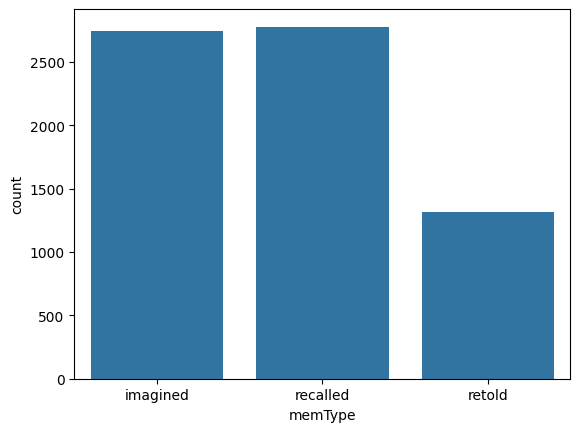

In [35]:
sns.countplot(data, x="memType")

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6854 entries, 0 to 6853
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AssignmentId       6854 non-null   object 
 1   WorkTimeInSeconds  6854 non-null   int64  
 2   WorkerId           6854 non-null   object 
 3   annotatorAge       6831 non-null   float64
 4   annotatorGender    6854 non-null   object 
 5   annotatorRace      6854 non-null   object 
 6   distracted         6854 non-null   float64
 7   draining           6854 non-null   float64
 8   frequency          4098 non-null   float64
 9   importance         6710 non-null   float64
 10  logTimeSinceEvent  6854 non-null   int64  
 11  mainEvent          6854 non-null   object 
 12  memType            6853 non-null   object 
 13  mostSurprising     6853 non-null   object 
 14  openness           6851 non-null   float64
 15  recAgnPairId       2618 non-null   object 
 16  recImgPairId       5326 

we have 6854 rows and 23 columns. However we have some missing values in our dataset

<Axes: >

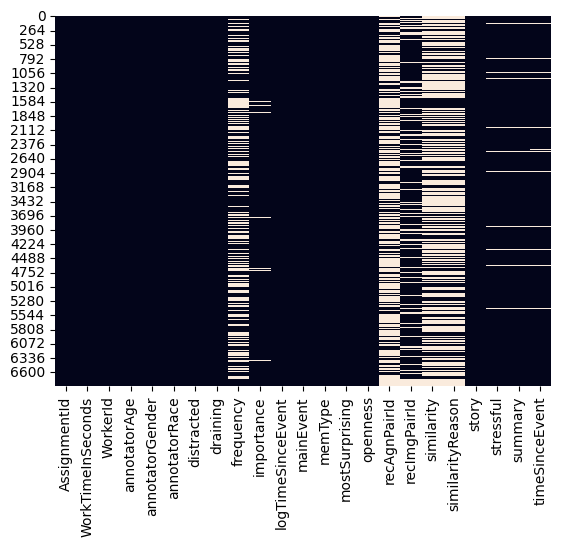

In [ ]:
sns.heatmap(data.isnull(), cbar=False)

## <a id='toc1_5_'></a>[Preprocessing](#toc0_)

In [16]:
data = data.dropna(subset=['story', 'memType'])
data[['frequency','similarity']] = data[['frequency','similarity']].fillna(0)

To handle missing values, we drop NaN values from the "story" and "memType" columns, as they are our main feature and label. Additionally, we fill NaN values in the "frequency" and "similarity" columns with 0 to minimize the loss of information. (While we do not currently use these features and rely solely on "story," this step is essential if we plan to build a pipeline that incorporates these features in the future.)

### <a id='toc1_5_1_'></a>[Text Preprocessing](#toc0_)

Preprocessing steps:

+ lower case
+ stemming
+ removing hashtags
+ remove stop words
+ tokenization
+ remove punctuation
+ removing double space

In [20]:
contains_hashtags = data['story'].str.contains(r'#').any()
print("Contains hashtags:", contains_hashtags)

contains_mentions = data['story'].str.contains(r'@[\w\-]+').any()
print("Contains mentions:", contains_mentions)

contains_urls = data['story'].str.contains(r"http\S+").any()
print("Contains URLs:", contains_urls)

Contains hashtags: True
Contains mentions: False
Contains URLs: False


In [28]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# preprocessing function
def preprocess_text(text):
    text = text.lower()
    
    text = re.sub(r'#', '', text)
    
    text = re.sub(r'[^\w\s]', '', text) 
    
    text = re.sub(r'\s+', ' ', text).strip()
    
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    tokens = word_tokenize(text)
    
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(stemmed_tokens)
 
 
data['story_preprocessed'] = data['story'].apply(preprocess_text)

In [ ]:
word_counts = [len(text.split()) for text in data['story_preprocessed']]
data['word_counts'] = word_counts
data['word_counts'].describe()

count    6843.000000
mean      115.770568
std        42.227869
min         0.000000
25%        87.000000
50%       111.000000
75%       139.000000
max       302.000000
Name: word_counts, dtype: float64

## <a id='toc1_6_'></a>[Feature Engineering](#toc0_)

We aim to determine whether there are any stories with lengths that are either too short or too long.

In [31]:
Q1 = np.percentile(data['word_counts'], 25)
Q3 = np.percentile(data['word_counts'], 75)
IQR = Q3 - Q1

min_thr = Q1 - 1.5*IQR
max_thr = Q3 + 1.5*IQR

In [32]:
# stories that have a number of words below 1.5 std
data[data['word_counts'] < min_thr].loc[:,['memType','story','story_preprocessed','word_counts']].sort_values('word_counts', ascending=True, inplace=False)
     

,memType,story,story_preprocessed,word_counts
2685,recalled,This was it,,0
236,retold,"She is my oldest ""stepdaughter""",oldest stepdaught,2
2574,recalled,"Dear, diary",dear diari,2
739,recalled,I was bored with my job,bore job,2
5290,imagined,he day it happened was the same as most,day happen,2
1623,imagined,I have been working on packing up my apartment...,work pack apart,3
868,imagined,She stands in the front of the church,stand front church,3
2012,imagined,Two months ago I did it,two month ago,3
1673,recalled,It happened a few months ago,happen month ago,3
4616,imagined,I am very proud of myself as a father. I have ...,proud father two kid,4


In [33]:
# stories that have a number of words more than 1.5 std
data[data['word_counts'] > max_thr].loc[:,['memType','story','story_preprocessed','word_counts']].sort_values('word_counts', ascending=False, inplace=False)
     

,memType,story,story_preprocessed,word_counts
2882,retold,After HVAC school for one year I realized I wa...,hvac school one year realiz wasnt comfort amou...,302
3767,recalled,Recently I left a homeless shelter for vets I ...,recent left homeless shelter vet stay last two...,296
895,recalled,I was looking to buy a car but I didn't have t...,look buy car didnt transport time option limit...,285
5363,recalled,I was recently involved in a somewhat stressfu...,recent involv somewhat stress incid colleg bun...,285
3105,recalled,"Just last month, I went on a trip to Lassen Na...",last month went trip lassen nation park older ...,283
...,...,...,...,...
1597,retold,"The Monday of the week of the Fourth of July, ...",monday week fourth juli randomli went drink lo...,218
2771,recalled,"One event that was memorable, emotional and st...",one event memor emot strike social mistak made...,218
1178,imagined,"My mother have a heart disease, so I planned t...",mother heart diseas plan move assist live resi...,218
5331,imagined,Three months ago I was sitting on a barbecue p...,three month ago sit barbecu pit wait mother pi...,218


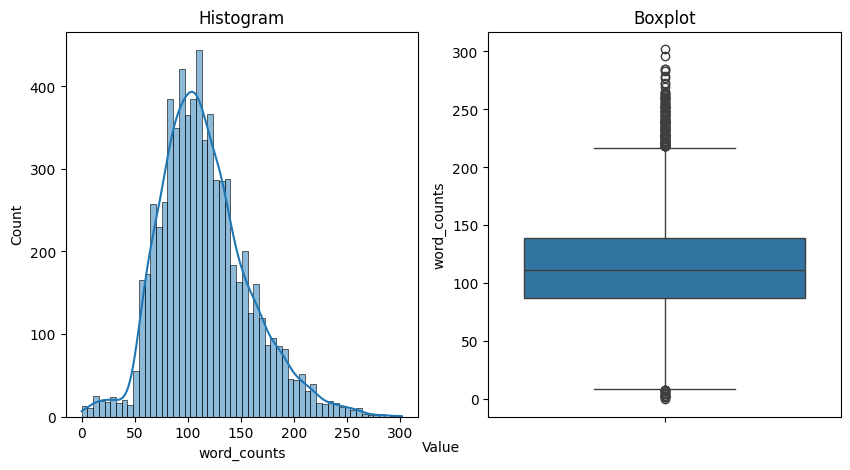

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the histogram using seaborn on the first axis
sns.histplot(data['word_counts'], ax=ax1, kde = True)
ax1.set_title('Histogram')

# Plot the boxplot using seaborn on the second axis
sns.boxplot(data['word_counts'], ax=ax2)
ax2.set_title('Boxplot')

# Add a common x-axis label
fig.text(0.5, 0.04, 'Value', ha='center')

# Show the plot
plt.show()

We decided to remove stories with a length less than Q1 - 1.5 * IQR, as they might not contain any useful information.

In [36]:
mask = data['word_counts'] < min_thr
data = data.drop(data[mask].index)

then we create a pipeline using tfidf as a feature and RandomForrest as a classifier.

In [ ]:
X = data['story_preprocessed']
y = pd.get_dummies(data['memType'], columns=['memType'])
y = np.array(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(min_df=0.05)),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', RandomForestClassifier())])

pipeline.fit(X_train, np.argmax(y_train, axis=1))  

y_pred = pipeline.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)  
print("Accuracy:", accuracy)

Accuracy: 0.5282051282051282



The accuracy of our model is 52%, which is not acceptable. However, it could be improved by tuning hyperparameters, experimenting with different algorithms, and defining additional features.

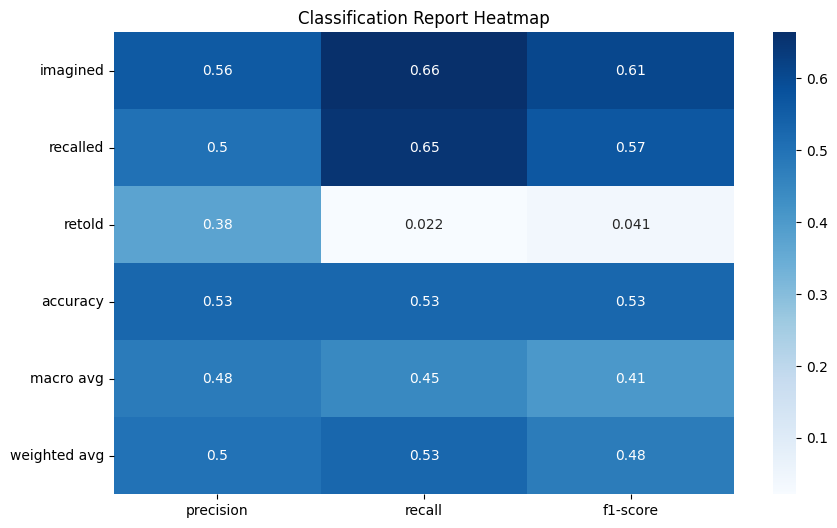

In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = y_pred

target_names = data['memType'].unique()

clf_report = classification_report(y_test_labels, y_pred_labels, target_names=target_names, output_dict=True)

clf_report_df = pd.DataFrame(clf_report)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(clf_report_df.iloc[:-1, :].T, annot=True, cmap='Blues', ax=ax)
ax.set_title('Classification Report Heatmap')
plt.show()

## <a id='toc1_7_'></a>[Transformers](#toc0_)

In this section, we will use a transformer to build a more robust model. Specifically, we employ DistilRoBERTa-base, a lightweight version of RoBERTa, due to time and computational limitations. Additionally, we sample 2,000 entries from our dataset for the same reason. The steps we follow are:

+ Choosing our text columns and labels
+ Converting our labels into numerical representations
+ Defining the number of classes
+ Tokenizing our stories
+ Preprocessing our stories:
    - Padding to ensure all inputs have the same length
    - Setting a maximum input length of 512 tokens
+ Defining "accuracy" as our evaluation metric
+ Training our model

In [ ]:
data = pd.read_excel("hcV3-stories.xlsx")
data = data.dropna(subset=['story', 'memType'])

### <a id='toc1_7_1_'></a>[Preprocessing](#toc0_)

In [4]:
sampled_data = data.groupby('memType', group_keys=False).apply(
    lambda x: x.sample(n=2000 // 3, random_state=42))

data = sampled_data.sample(frac=1, random_state=42).reset_index(drop=True)


In [5]:
data = data[["story", "memType"]]
data.columns = ["text", "label"]
le = sklearn.preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["label"])
number_of_classes = data["label"].nunique()

In [ ]:
data_train, data_test = sklearn.model_selection.train_test_split(data)

model_name = "distilroberta-base"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

data_train_encoded = datasets.Dataset.from_pandas(data_train).map(preprocess_function, batched=True)
data_test_encoded = datasets.Dataset.from_pandas(data_test).map(preprocess_function, batched=True)

Map: 100%|██████████| 250/250 [00:00<00:00, 2090.21 examples/s]


### <a id='toc1_7_2_'></a>[Training](#toc0_)

In [7]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=number_of_classes)

training_args = transformers.TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    report_to="none"
)

trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=data_train_encoded,
    eval_dataset=data_test_encoded,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Finally, we achieved an accuracy of 60% for our model. This performance can be further improved by adjusting the model's hyperparameters, such as the learning rate, batch size, weight decay, and others.